# Camera Registry
Load in all available cameras and list out their parameters.

In [1]:
from imagedaemon import registry
available_cameras = registry.available()
print("Registered cameras:", available_cameras)

# check the camera parameters
for camname in available_cameras:
    camera = registry.get(camname)
    print("camera:")
    for entry in camera.meta:
        print(f"\t {entry}")

PROJECT_ROOT = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon
CONFIG_DIR = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/imagedaemon/config
astro_scamp = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/imagedaemon/config/scamp.conf
masterbias_dir = /Users/nlourie/data/image-daemon-data/calibration/masterbias
Registered cameras: ['qcmos', 'summer-ccd', 'winter']
camera:
	 ('name', 'qcmos')
	 ('pixel_scale', 0.157)
	 ('scale_margin', 0.05)
	 ('hot_pixel_threshold', 200)
	 ('cal_steps', {'dark': False, 'lab_flat': False, 'dither_flat': False, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'mask_hot_pixels': True, 'replace_nans_with_median': True})
	 ('focus_addrs', [])
	 ('focus_cal_steps', {'dark': True, 'lab_flat': False, 'dither_flat': True, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'mask_hot_pixels': False, 'replace_nans_with_median': True})
	 ('focus_

# WINTER Pipeline
These code blocks demonstrate using the imagedaemon modules and pipeline API to run a basic calibration routine that mirrors the expected approach for generating sky models, and then run astrometry on the calibrated image.

In [2]:
from imagedaemon.pipelines.base import BasePipelines
from imagedaemon.cameras.winter.meta import WinterMeta

pipeline = BasePipelines(WinterMeta())   # note the () ← instantiate


[I imagedaemon.pipeline] Calibration started | camera=winter image=/Users/nlourie/data/image-daemon-data/raw/winter/science/30s/WINTERcamera_20250507-103738-584_mef.fits


Using 4 background images with science image
data: [array([[39297., 39259., 39898., ..., 10245.,  4457.,  4478.],
       [39846., 40057., 39644., ..., 10674.,  4448.,  4639.],
       [10271., 10186.,  4401., ..., 11344.,  4442.,  4448.],
       ...,
       [10526., 11162.,  4479., ..., 10978.,  4471.,  4664.],
       [10605., 10515.,  4435., ..., 10730.,  4436.,  4447.],
       [10722., 10963.,  4466., ..., 11195.,  4489.,  4679.]],
      dtype=float32), array([[39368., 39333., 39990., ..., 10234.,  4458.,  4467.],
       [39910., 40130., 39719., ..., 10751.,  4456.,  4647.],
       [10259., 10170.,  4404., ..., 11368.,  4437.,  4449.],
       ...,
       [10602., 11206.,  4485., ..., 10977.,  4480.,  4673.],
       [10587., 10504.,  4423., ..., 10745.,  4449.,  4461.],
       [10701., 10922.,  4465., ..., 11229.,  4492.,  4684.]],
      dtype=float32), array([[39340., 39286., 39960., ..., 10271.,  4437.,  4450.],
       [39866., 40095., 39688., ..., 10706.,  4457.,  4650.],
       [10

/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:42: RuntimeWarning: divide by zero encountered in divide
  return data / flat_data
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:42: RuntimeWarning: invalid value encountered in divide
  return data / flat_data
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/.conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/.conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


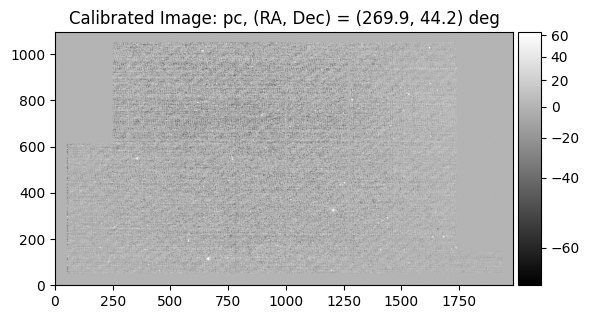

In [3]:
# let's try to run the winter calibration pipeline
from imagedaemon.utils.paths import RAW_DATA_DIR
import os
from glob import glob

addr = "pc"


winter = registry.get("winter")

bkg_dir = os.path.join(RAW_DATA_DIR, "winter", "science", "30s", "bkg")
science_dir = os.path.join(RAW_DATA_DIR, "winter", "science", "30s")

bkg_images = sorted(glob(os.path.join(bkg_dir, "*mef.fits")))
MAX_BKG_IMAGES = 3

bkg_images = bkg_images[:MAX_BKG_IMAGES]
science_images = sorted(glob(os.path.join(science_dir, "*mef.fits")))
science_image = science_images[0]

use_science_in_bkg = True

if use_science_in_bkg:
    bkg_images = [science_image] + bkg_images
    print(f"Using {len(bkg_images)} background images with science image")
else:
    print(f"Using {len(bkg_images)} background images without science image")

calimg = winter.calibrate_image(addr = addr, 
                                 science_image = science_image, 
                                 background_image_list = bkg_images)

# try to save the calibrated image
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))

# take a look at the header
#for card in calimg.header.cards:
#    print(card)

# plot the calibrated image!
ra_guess, dec_guess = calimg.header["RADEG"], calimg.header["DECDEG"]
calimg.plot_image(title = f"Calibrated Image: {addr}, (RA, Dec) = ({ra_guess:.1f}, {dec_guess:.1f}) deg",)


calimg.save_image(os.path.join(output_dir, "calibrated_img.fits"))

In [4]:




# run the full astrometric pipeline
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))
info = winter.get_astrometric_solution(addr = addr,
                                      science_image = science_image,
                                      background_image_list = bkg_images,
                                      output_dir = output_dir,
    )

wcs = info["wcs"]



[I imagedaemon.pipeline] Calibration started | camera=winter image=/Users/nlourie/data/image-daemon-data/raw/winter/science/30s/WINTERcamera_20250507-103738-584_mef.fits


data: [array([[39297., 39259., 39898., ..., 10245.,  4457.,  4478.],
       [39846., 40057., 39644., ..., 10674.,  4448.,  4639.],
       [10271., 10186.,  4401., ..., 11344.,  4442.,  4448.],
       ...,
       [10526., 11162.,  4479., ..., 10978.,  4471.,  4664.],
       [10605., 10515.,  4435., ..., 10730.,  4436.,  4447.],
       [10722., 10963.,  4466., ..., 11195.,  4489.,  4679.]],
      dtype=float32), array([[39368., 39333., 39990., ..., 10234.,  4458.,  4467.],
       [39910., 40130., 39719., ..., 10751.,  4456.,  4647.],
       [10259., 10170.,  4404., ..., 11368.,  4437.,  4449.],
       ...,
       [10602., 11206.,  4485., ..., 10977.,  4480.,  4673.],
       [10587., 10504.,  4423., ..., 10745.,  4449.,  4461.],
       [10701., 10922.,  4465., ..., 11229.,  4492.,  4684.]],
      dtype=float32), array([[39340., 39286., 39960., ..., 10271.,  4437.,  4450.],
       [39866., 40095., 39688., ..., 10706.,  4457.,  4650.],
       [10267., 10203.,  4477., ..., 11395.,  4451.,  4

/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:42: RuntimeWarning: divide by zero encountered in divide
  return data / flat_data
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:42: RuntimeWarning: invalid value encountered in divide
  return data / flat_data
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/.conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Reading input file 1 of 1: "/Users/nlourie/data/tmp/WINTERcamera_20250507-103738-584_mef.cal.fits"...
Running command: /opt/homebrew/bin/image2pnm --infile /Users/nlourie/data/tmp/WINTERcamera_20250507-103738-584_mef.cal.fits --uncompressed-outfile /tmp/tmp.uncompressed.1zy1IF --outfile /tmp/tmp.ppm.vSIXTW --ppm --mydir /opt/homebrew/bin/solve-field
Extracting sources...
Downsampling by 2...
simplexy: found 1495 sources.
Solving...
fitsbin.c:449:read_chunk: Couldn't find table "kdtree_data_codes" in file "/opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits"
index.c:329:index_reload: Failed to read star kdtree from file /opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits
engine.c:199:engine_add_index: Failed to load index from path /opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits
Failed to add index "/opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits".
fitsbin.c:449:read_chunk: Couldn't find table "kdtree_data_stars" in file "/opt/

In [5]:
# report back the RA/Dec of a specified pixel location
x_pix, y_pix = 1950, 550

from imagedaemon.utils.wcs_utils import pix2sky
sky_pos = pix2sky(x_pix, y_pix, wcs)
print(
    f"Coord conversion: (x, y) = ({x_pix}, {y_pix}) -> (RA, Dec) = ({sky_pos.ra:.1f}, {sky_pos.dec:.1f}) deg"
)

# print it back in DS9 format
print(
    f"Pixel coords: (x, y) = ({x_pix:.1f}, {y_pix:.1f}) -> (x, y) = ({sky_pos.to_string('hmsdms', precision=2)}, {sky_pos.to_string('hmsdms', precision=2)})"
)


Coord conversion: (x, y) = (1950, 550) -> (RA, Dec) = (269.9 deg, 44.6 deg) deg
Pixel coords: (x, y) = (1950.0, 550.0) -> (x, y) = (17h59m42.55s +44d38m16.06s, 17h59m42.55s +44d38m16.06s)


# qCMOS Pipelines

Now we will try to run astrometry on a sample qcmos image.

This pipeline has basically no steps: just run astrometry directly on the image

In [6]:
qcmos = registry.get("qcmos")

image_dir = os.path.join(RAW_DATA_DIR, "qcmos", "science")
science_images = sorted(glob(os.path.join(image_dir, "*8s*.fits")))
science_image = science_images[0]
print(f"Science image: {science_image}")

# run the full astrometric pipeline
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))

# this image has no RA/Dec in the header, so we need to set it
ra_guess = 83.6
dec_guess = 22


info = qcmos.get_astrometric_solution(science_image = science_image,
                                      background_image_list = None,
                                      output_dir = output_dir,
                                      ra = ra_guess,
                                      dec = dec_guess,
    )
wcs = info["wcs"]

print()
print(f"Astrometric solution:")
import json
# use json.dumps to pretty print the dictionary but NOT the wcs which is a special object
info_to_print = info.copy()
info_to_print.pop("wcs")
print()
print(f"info: {json.dumps(info_to_print, indent = 2)}")

# the image is 4096 x 2304
wx = 4096
wy = 2304
# let's try to get the WCS for a pixel in the center of the image
x_pix, y_pix = wx // 2, wy // 2
sky_pos = pix2sky(x_pix, y_pix, wcs)
print(
    f"Coord conversion: (x, y) = ({x_pix}, {y_pix}) -> (RA, Dec) = ({sky_pos.ra:.1f}, {sky_pos.dec:.1f}) deg"
)

[I imagedaemon.pipeline] Calibration started | camera=qcmos image=/Users/nlourie/data/image-daemon-data/raw/qcmos/science/8s_image_single.fits


Science image: /Users/nlourie/data/image-daemon-data/raw/qcmos/science/8s_image_single.fits
[astrometry] solve-field /Users/nlourie/data/tmp/8s_image_single.cal.fits --scale-units arcsecperpix --scale-low 0.14915 --scale-high 0.16485 --ra 83.6 --dec 22 --radius 2.0 --downsample 2 --overwrite --no-plots --cpulimit 30 

Reading input file 1 of 1: "/Users/nlourie/data/tmp/8s_image_single.cal.fits"...
Running command: /opt/homebrew/bin/image2pnm --infile /Users/nlourie/data/tmp/8s_image_single.cal.fits --uncompressed-outfile /tmp/tmp.uncompressed.oasfdL --outfile /tmp/tmp.ppm.lhEViy --ppm --mydir /opt/homebrew/bin/solve-field
Extracting sources...
Downsampling by 2...
simplexy: found 922 sources.
Solving...
fitsbin.c:449:read_chunk: Couldn't find table "kdtree_data_codes" in file "/opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits"
index.c:329:index_reload: Failed to read star kdtree from file /opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits
engine.c:199:engin

In [7]:
# try again with the 1s qCMOS image
qcmos = registry.get("qcmos")

image_dir = os.path.join(RAW_DATA_DIR, "qcmos", "science")
science_images = sorted(glob(os.path.join(image_dir, "*1s*.fits")))
science_image = science_images[0]
print(f"Science image: {science_image}")

# run the full astrometric pipeline
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))

# this image has no RA/Dec in the header, so we need to set it
ra_guess = 123.0
dec_guess = 25.0


info = qcmos.get_astrometric_solution(science_image = science_image,
                                      background_image_list = None,
                                      output_dir = output_dir,
                                      ra = ra_guess,
                                      dec = dec_guess,
    )
wcs = info["wcs"]
# the image is 4096 x 2304
wx = 4096
wy = 2304
# let's try to get the WCS for a pixel in the center of the image
x_pix, y_pix = wx // 2, wy // 2
sky_pos = pix2sky(x_pix, y_pix, wcs)
print(
    f"Coord conversion: (x, y) = ({x_pix}, {y_pix}) -> (RA, Dec) = ({sky_pos.ra:.1f}, {sky_pos.dec:.1f}) deg"
)

[I imagedaemon.pipeline] Calibration started | camera=qcmos image=/Users/nlourie/data/image-daemon-data/raw/qcmos/science/1s_image_single.fits


Science image: /Users/nlourie/data/image-daemon-data/raw/qcmos/science/1s_image_single.fits
[astrometry] solve-field /Users/nlourie/data/tmp/1s_image_single.cal.fits --scale-units arcsecperpix --scale-low 0.14915 --scale-high 0.16485 --ra 123.0 --dec 25.0 --radius 2.0 --downsample 2 --overwrite --no-plots --cpulimit 30 

Reading input file 1 of 1: "/Users/nlourie/data/tmp/1s_image_single.cal.fits"...
Running command: /opt/homebrew/bin/image2pnm --infile /Users/nlourie/data/tmp/1s_image_single.cal.fits --uncompressed-outfile /tmp/tmp.uncompressed.MjWBAR --outfile /tmp/tmp.ppm.d5Erks --ppm --mydir /opt/homebrew/bin/solve-field
Extracting sources...
Downsampling by 2...
simplexy: found 1112 sources.
Solving...
fitsbin.c:449:read_chunk: Couldn't find table "kdtree_data_codes" in file "/opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits"
index.c:329:index_reload: Failed to read star kdtree from file /opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits
engine.c:199:e

Science image: /Users/nlourie/data/image-daemon-data/raw/summer-ccd/science/r-band/SUMMER_20221026_201136_Camera0.fits


[I imagedaemon.pipeline] Calibration started | camera=summer-ccd image=/Users/nlourie/data/image-daemon-data/raw/summer-ccd/science/r-band/SUMMER_20221026_201136_Camera0.fits


[astrometry] solve-field /Users/nlourie/data/tmp/SUMMER_20221026_201136_Camera0.cal.fits --scale-units arcsecperpix --scale-low 0.14915 --scale-high 0.16485 --ra 322.0236809106472 --dec 47.59157654665 --radius 2.0 --downsample 2 --overwrite --no-plots --cpulimit 30 

Reading input file 1 of 1: "/Users/nlourie/data/tmp/SUMMER_20221026_201136_Camera0.cal.fits"...
Running command: /opt/homebrew/bin/image2pnm --infile /Users/nlourie/data/tmp/SUMMER_20221026_201136_Camera0.cal.fits --uncompressed-outfile /tmp/tmp.uncompressed.JAgoaw --outfile /tmp/tmp.ppm.kLE5Ir --ppm --mydir /opt/homebrew/bin/solve-field
Extracting sources...
Downsampling by 2...
Failed to estimate the image noise.  Setting sigma=1.  Expect the worst.
No pixels were marked as significant.
  significance threshold = 2.25676
  max value in image = 0.0470591
Downsampling by 2...
No pixels were marked as significant.
  significance threshold = 2.25676
  max value in image = 0.0101779
Downsampling by 2...
No pixels were marked 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nlourie/data/tmp/SUMMER_20221026_201136_Camera0.cal.new'

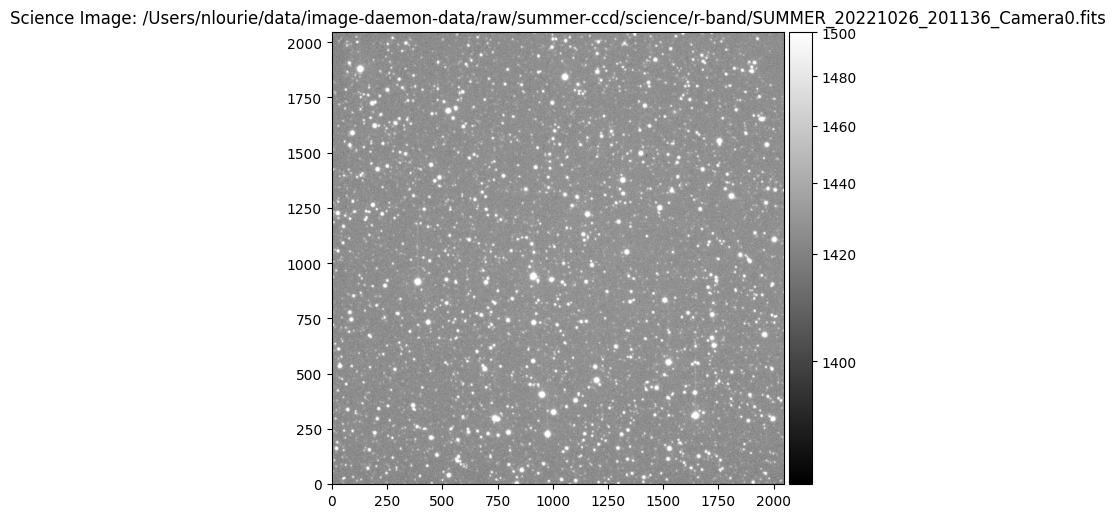

In [ ]:
# now run astrometry on a summer-ccd image

# try again with a full summer-ccd image
summerccd = registry.get("summer-ccd")

image_dir = os.path.join(RAW_DATA_DIR, "summer-ccd", "science", "r-band")
science_images = sorted(glob(os.path.join(image_dir, "*.fits")))
science_image = science_images[0]
print(f"Science image: {science_image}")

# plot the image just for fun
from imagedaemon.utils.image import Image
image = Image(science_image)
image.plot_image(title = f"Science Image: {image.filename}",)

# run the full astrometric pipeline
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))

# this image has no RA/Dec in the header, so we need to set it
ra_guess = None
dec_guess = None


info = summerccd.get_astrometric_solution(science_image = science_image,
                                      background_image_list = None,
                                      output_dir = output_dir,
                                      ra = ra_guess,
                                      dec = dec_guess,
    )
wcs = info["wcs"]
# the image is 4096 x 2304
wx = 2048
wy = 2049
# let's try to get the WCS for a pixel in the center of the image
x_pix, y_pix = wx // 2, wy // 2
sky_pos = pix2sky(x_pix, y_pix, wcs)
print(
    f"Coord conversion: (x, y) = ({x_pix}, {y_pix}) -> (RA, Dec) = ({sky_pos.ra:.1f}, {sky_pos.dec:.1f}) deg"
)